# Notebook de diseño de la Red Predictiva Fintech_LSTM

### Celdas de carga de librerías, paquetes, etc...

In [1]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [2]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Done!


### Definición de la red neuronal

In [108]:
####################################################################################
# PASO 12: Crea diferentes callbacks para su ejecución durante el proceso de entrenamiento
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

####################################################################################
# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [109]:
####################################################################################
# PASO 13: Elije el archivo en el que se guardarán los pesos del modelo entrenado
file_weights = "model_weights_3010003.hdf5"

####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
batch_size=64
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit.csv" updated
Loaded weights from file:  model_weights_3010003.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 24, 128)           69632     
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 128)           131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________

### Celdas de carga de datos históricos desde archivo csv a Pandas Dataframe

- Cargo el histórico en dataframe
- Puedo reindexar el timestamp a una cadencia fija (ej. 1 hora) y rellenar los gaps (NaN)
- Puedo visualizar el resultado en forma de gráfico de velas
- Añado tantas filas al final como predicciones se vayan a hacer

In [3]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'12syio4J4xs-PFo_qNNWsNKvQhZb0nOaY'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_H1.csv')  
  #downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('EURUSD_M30.csv')  
  #downloaded = drive.CreateFile({'id':'18o564BOnayxVbbY2DR7BjGXY-zzk9PBd'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('test_fourier.csv')  

In [3]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1_now.csv',sep=';', reindex_fillna=True, plot_it=False)   

# defino número de predicciones
num_out_steps = 4
delta = df.index[1] - df.index[0]
max_index = df.index[-1] + (num_out_steps*delta)
new_index = pd.date_range(min(df.index), max_index, freq="1H")
df = df.reindex(new_index)
df.loc[-num_out_steps:,:]=0
plot_resume = False
if plot_resume:
    # visualizo una sección
    trace = go.Candlestick(x=df.index[-100:],
                                   open=df.OPEN[-100:],
                                   high=df.HIGH[-100:],
                                   low=df.LOW[-100:],
                                   close=df.CLOSE[-100:])
    data = [trace]
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=700,    
        title='Mostrando últimos 100 datos',
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
df.tail(10)
    

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.10.01  00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1  2001.10.01  01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2  2001.10.01  02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3  2001.10.01  03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4  2001.10.01  04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-10-01 00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1 2001-10-01 01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2 2001-10-01 02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3 2001-10-01 03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4 2001-10-01 04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
                    

,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
2018-10-30 09:00:00,1.13783,1.13808,1.13704,1.13743,2198.0,0.0,0.0
2018-10-30 10:00:00,1.13743,1.13877,1.13581,1.13635,8243.0,0.0,0.0
2018-10-30 11:00:00,1.13635,1.13800,1.13605,1.13779,7471.0,0.0,0.0
2018-10-30 12:00:00,1.13779,1.13790,1.13650,1.13654,7445.0,0.0,0.0
2018-10-30 13:00:00,1.13654,1.13657,1.13507,1.13576,7598.0,0.0,0.0
2018-10-30 14:00:00,1.13576,1.13588,1.13456,1.13467,6938.0,0.0,0.0
2018-10-30 15:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-30 16:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-30 17:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0
2018-10-30 18:00:00,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0


###  Elaboración de indicadores técnicos sintéticos

A partir de los datos OHLC, y la librería TA-Lib genero diversos indicadores sintéticos. En este caso he optado por predecir el precio de cierre 'close' y por lo tanto, todos los indicadores se aplicarán a dicho precio (aunque se podrían utilizar otros precios como 'high', 'low', 'open', etc...).

- bollWidthRel: Aporta la anchura de las bandas bollinger relativa a su propia SMA100
- bollR: Aporta la posición del precio en relación a la banda bollinger en %
- atr: Aporta la diferencia entre éste y el cierre de la sesión anterior
- SMAx3: Aporta 3 medias simples de 4,16 y 40 periodos
- Además también puedo añadir el propio precio ('close')

In [4]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, applied, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    cols = list()
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                df['sma4_'+p] = talib.SMA(df.CLOSE,timeperiod=4)
                df['sma16_'+p] = talib.SMA(df.CLOSE,timeperiod=16)
                df['sma40_'+p] = talib.SMA(df.CLOSE,timeperiod=40)
                cols.append('sma4_'+p)
                cols.append('sma16_'+p)
                cols.append('sma40_'+p)
              
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))
    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df.dropna(inplace=True)    
    df = df[cols]
    if plot_it:
        plt.figure(figsize=(12,12))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(df[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    return df

####################################################################################
####################################################################################

dfapp = add_indicators(df, ['CLOSE'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True)
dfapp['out'] = dfapp['CLOSE']
dfapp.tail()



,bollWidthRel_CLOSE,bollR_CLOSE,atr_CLOSE,sma4_CLOSE,sma16_CLOSE,sma40_CLOSE,CLOSE,out
2018-10-30 14:00:00,0.644573,-1.992708e-01,-0.000184,1.136190e+00,1.137209,1.138345,1.13467,1.13467
2018-10-30 15:00:00,15.086422,-5.897159e-01,-0.081236,8.517425e-01,1.066134,1.109841,0.00000,0.00000
2018-10-30 16:00:00,9.245722,-2.499971e-01,-0.081254,5.676075e-01,0.995057,1.081346,0.00000,0.00000
2018-10-30 17:00:00,6.627836,-9.511766e-02,-0.081259,2.836675e-01,0.923975,1.052836,0.00000,0.00000
2018-10-30 18:00:00,5.136228,8.257969e-07,-0.081254,1.110223e-14,0.852877,1.024342,0.00000,0.00000


###  Adaptación de los datos para ejecución de la predicción 

El dataframe cargado tiene como último dato, la vela actual. Para evitar que durante la adaptación a 'supervised' se eliminen celdas válidas debido al dropna, es necesario añadir tantas filas al final como timesteps a generar en la predicción. De esta forma conseguimos que tras el dropna, la última fila sea exactamente la muestra actual.

In [5]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in-1, -1, -1):
    cols.append(df_in.shift(i))
    if i!=0:
      names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    else:
      names += [('%s(t)' % (df_in.columns[j])) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(1, n_out+1):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 24
#num_out_steps = 4 (ver arriba)
num_outputs = 1
num_inputs = dfapp.shape[1] - num_outputs

sts_src = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, num_out_steps)
print('Número de muestras total: ', sts_df.shape[0])
sts_src.tail(10)

Número de muestras total:  149631


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2018-10-30 05:00:00,0.366743,0.193291,-0.000050,1.139213,1.139892,1.140053,1.13946,0.438899,0.083963,-0.000069,...,0.471577,-0.000030,1.137735,1.138092,1.139065,1.13820,1.13819,1.13810,1.13783,1.13743
2018-10-30 06:00:00,0.438899,0.083963,-0.000069,1.139268,1.139831,1.140028,1.13919,0.497197,0.336316,-0.000041,...,0.505845,0.000082,1.137893,1.138015,1.139015,1.13819,1.13810,1.13783,1.13743,1.13635
2018-10-30 07:00:00,0.497197,0.336316,-0.000041,1.139380,1.139796,1.140014,1.13959,0.591864,0.179476,-0.000064,...,0.478494,-0.000029,1.138010,1.137982,1.138964,1.13810,1.13783,1.13743,1.13635,1.13779
2018-10-30 08:00:00,0.591864,0.179476,-0.000064,1.139375,1.139739,1.139992,1.13926,0.766196,1.007279,0.000049,...,0.388190,-0.000081,1.138080,1.138032,1.138906,1.13783,1.13743,1.13635,1.13779,1.13654
2018-10-30 09:00:00,0.766196,1.007279,0.000049,1.139723,1.139782,1.140009,1.14085,1.069089,-0.118870,-0.000132,...,0.269333,-0.000034,1.137888,1.137964,1.138837,1.13743,1.13635,1.13779,1.13654,1.13576
2018-10-30 10:00:00,1.069089,-0.118870,-0.000132,1.139503,1.139667,1.139963,1.13831,1.418193,-0.106269,-0.000157,...,-0.058552,-0.000175,1.137428,1.137801,1.138742,1.13635,1.13779,1.13654,1.13576,1.13467
2018-10-30 11:00:00,1.418193,-0.106269,-0.000157,1.139095,1.139529,1.139908,1.13796,1.490138,0.462495,-0.000046,...,0.475471,-0.000087,1.137350,1.137794,1.138683,1.13779,1.13654,1.13576,1.13467,0.00000
2018-10-30 12:00:00,1.490138,0.462495,-0.000046,1.139160,1.139489,1.139892,1.13952,1.492387,0.442263,-0.000026,...,0.045908,-0.000141,1.137028,1.137652,1.138592,1.13654,1.13576,1.13467,0.00000,0.00000
2018-10-30 13:00:00,1.492387,0.442263,-0.000026,1.138805,1.139444,1.139873,1.13943,1.482046,0.181015,-0.000127,...,-0.087184,-0.000103,1.136610,1.137449,1.138482,1.13576,1.13467,0.00000,0.00000,0.00000
2018-10-30 14:00:00,1.482046,0.181015,-0.000127,1.138883,1.139347,1.139835,1.13862,1.716890,-0.169727,-0.000196,...,-0.199271,-0.000184,1.136190,1.137209,1.138345,1.13467,0.00000,0.00000,0.00000,0.00000


### Normalización de los datos de entrada-salida

A continuación, se realiza la selección final de columnas del dataframe que se utilizará en la red neuronal y los datos se normalizarán utilizando un 'scaler' concreto. Dicho scaler se utilizará tras el proceso de predicción, para volver a de-normalizar el resultado y obtener su valor real.

Es posible reutilizar un scaler previamente guardado en disco, para ello activar el flag reuse_saved_scaler.

In [9]:
reuse_saved_scaler = False

# preparo los datos con numpy ndarray
values = sts_src.values
values = values.astype('float32')

if reuse_saved_scaler:
  # recupero el scaler del disco
  from sklearn.externals import joblib
  scaler_filename = "scaler.save"
  scaler = joblib.load(scaler_filename)  
  values = scaler.transform(values)
else:
  scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  values = scaler.fit_transform(values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=values, columns=sts_src.columns, index=sts_src.index)
sts_values = sts_scaled.values
sts_scaled.tail(10)


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2018-10-30 05:00:00,-0.955991,-0.281484,-0.093851,-0.242699,-0.240576,-0.238908,-0.242813,-0.947332,-0.381804,-0.099676,...,-0.026127,-0.087810,-0.246685,-0.245442,-0.241600,-0.246201,0.421316,0.421204,0.420867,0.420367
2018-10-30 06:00:00,-0.947332,-0.381804,-0.099676,-0.242551,-0.240739,-0.238975,-0.243539,-0.940336,-0.150244,-0.091046,...,0.005317,-0.053937,-0.246260,-0.245651,-0.241734,-0.246228,0.421204,0.420867,0.420367,0.419018
2018-10-30 07:00:00,-0.940336,-0.150244,-0.091046,-0.242247,-0.240836,-0.239013,-0.242463,-0.928976,-0.294161,-0.098166,...,-0.019780,-0.087594,-0.245943,-0.245739,-0.241874,-0.246470,0.420867,0.420367,0.419018,0.420817
2018-10-30 08:00:00,-0.928976,-0.294161,-0.098166,-0.242261,-0.240988,-0.239075,-0.243351,-0.908056,0.465436,-0.063862,...,-0.102644,-0.103128,-0.245754,-0.245606,-0.242033,-0.247196,0.420367,0.419018,0.420817,0.419256
2018-10-30 09:00:00,-0.908056,0.465436,-0.063862,-0.241323,-0.240871,-0.239028,-0.239075,-0.871709,-0.567925,-0.118662,...,-0.211708,-0.089105,-0.246274,-0.245788,-0.242219,-0.248272,0.419018,0.420817,0.419256,0.418282
2018-10-30 10:00:00,-0.871709,-0.567925,-0.118662,-0.241917,-0.241184,-0.239153,-0.245906,-0.829817,-0.556362,-0.126214,...,-0.512577,-0.131607,-0.247515,-0.246229,-0.242478,-0.251177,0.420817,0.419256,0.418282,0.416921
2018-10-30 11:00:00,-0.829817,-0.556362,-0.126214,-0.243016,-0.241556,-0.239304,-0.246847,-0.821183,-0.034461,-0.092557,...,-0.022554,-0.105070,-0.247724,-0.246250,-0.242640,-0.247304,0.419256,0.418282,0.416921,-1.000000
2018-10-30 12:00:00,-0.821183,-0.034461,-0.092557,-0.242841,-0.241664,-0.239347,-0.242651,-0.820914,-0.053026,-0.086516,...,-0.416723,-0.121251,-0.248594,-0.246632,-0.242886,-0.250665,0.418282,0.416921,-1.000000,-1.000000
2018-10-30 13:00:00,-0.820914,-0.053026,-0.086516,-0.243798,-0.241787,-0.239397,-0.242894,-0.822154,-0.292749,-0.117152,...,-0.538849,-0.109817,-0.249720,-0.247181,-0.243186,-0.252764,0.416921,-1.000000,-1.000000,-1.000000
2018-10-30 14:00:00,-0.822154,-0.292749,-0.117152,-0.243589,-0.242048,-0.239501,-0.245072,-0.793973,-0.614591,-0.138080,...,-0.641701,-0.134196,-0.250853,-0.247830,-0.243559,-0.255695,-1.000000,-1.000000,-1.000000,-1.000000


# EJECUCIÓN

##### Chequeo el resultado de aplicar el conjunto de test para obtener el par (Loss, Accuracy)

In [105]:
# Realizo predicción 
x = sts_scaled.values[-1,0:num_inputs*num_in_steps].reshape(1, num_in_steps, num_inputs)
predictions = model.predict(x, batch_size=1,verbose=0)

# deshago el scaling
xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
xyhat_values = scaler.inverse_transform(xyhat_values)



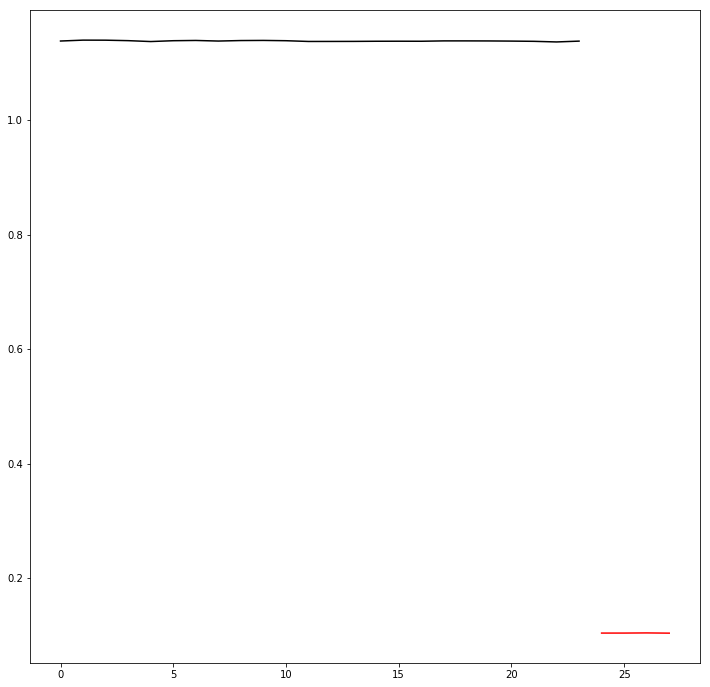

In [107]:
# Visualizo resultado
       
plt.figure(figsize=(12,12))        
plt.plot(sts_src.iloc[-num_in_steps:]['CLOSE(t-1)'].values, color='black')
plt.plot(np.arange(num_in_steps, num_in_steps + num_out_steps), xyhat_values[0,-(num_outputs*num_out_steps):], color='red')
